In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import optax

from jaxparrow.cyclogeostrophy import _iterative, _variational, LR_VAR
from jaxparrow.geostrophy import _geostrophy
from jaxparrow.tools.kinematics import magnitude
from jaxparrow.tools.operators import interpolation
from jaxparrow.tools.sanitize import init_mask

sys.path.extend([os.path.join(os.path.dirname(os.getcwd()), "tests")])
from tests import gaussian_eddy as ge  # noqa

%reload_ext autoreload
%autoreload 2

# Gaussian eddy

We want to use a gaussian eddy for our functional tests, as analytical solutions can be derived in that setting.

The gaussian eddy we consider is of the form $\eta = \eta_0 \exp^{-(r/R_0)^2}$, with $R_0$ its radius, $\eta_0$ the SSH anomaly at its center, and $r$ the radial distance. 
We choose to use a constant spatial step in meters.

In [2]:
# Alboran sea settings
R0 = 50e3
ETA0 = .1
LAT = 36

dxy = 15e3

## Simulating the eddy

In [3]:
X, Y, R, stencil_weights, coriolis_factor, ssh, u_geos_t, v_geos_t, u_cyclo_t, v_cyclo_t, = ge.simulate_gaussian_eddy(
    R0, 
    dxy, 
    ETA0, 
    LAT
)

We just make sure that the grids are correct.

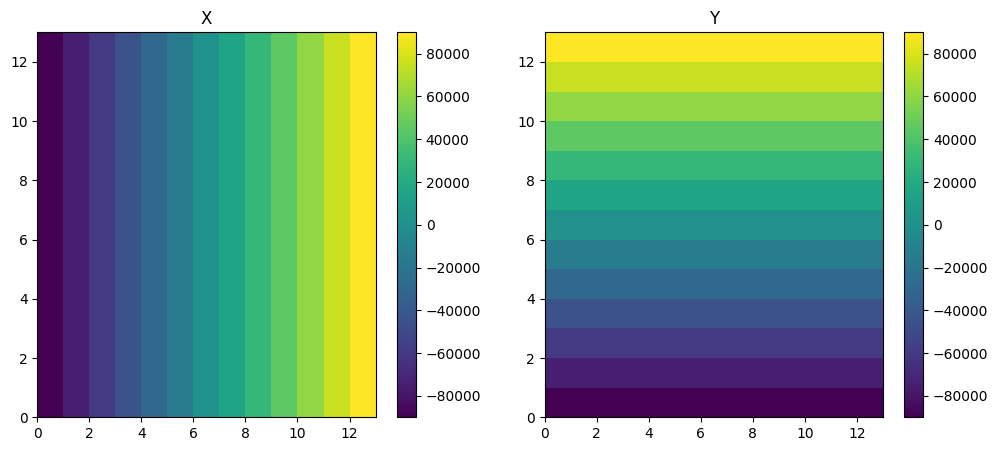

In [4]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("X")
im = ax1.pcolormesh(X, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("Y")
im = ax2.pcolormesh(Y, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

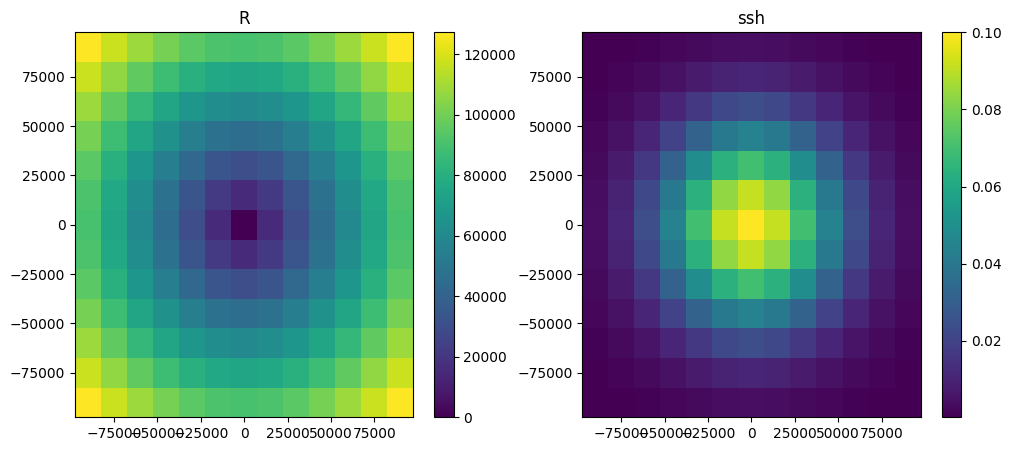

In [5]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.set_title("R")
im = ax1.pcolormesh(X, Y, R, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("ssh")
im = ax2.pcolormesh(X, Y, ssh, shading="auto")
plt.colorbar(im, ax=ax2)
plt.show()

## Geostrophy

### Analytical

$$u_g = 2y \frac{g \eta_0}{f R_0^2} \exp^{-(r/R_0)^2} = 2y \frac{g \eta}{f R_0^2}$$

$$v_g = -2x \frac{g \eta_0}{f R_0^2} \exp^{-(r/R_0)^2} = -2x \frac{g \eta}{f R_0^2}$$

In [6]:
azim_geos = magnitude(u_geos_t, v_geos_t, interpolate=False)

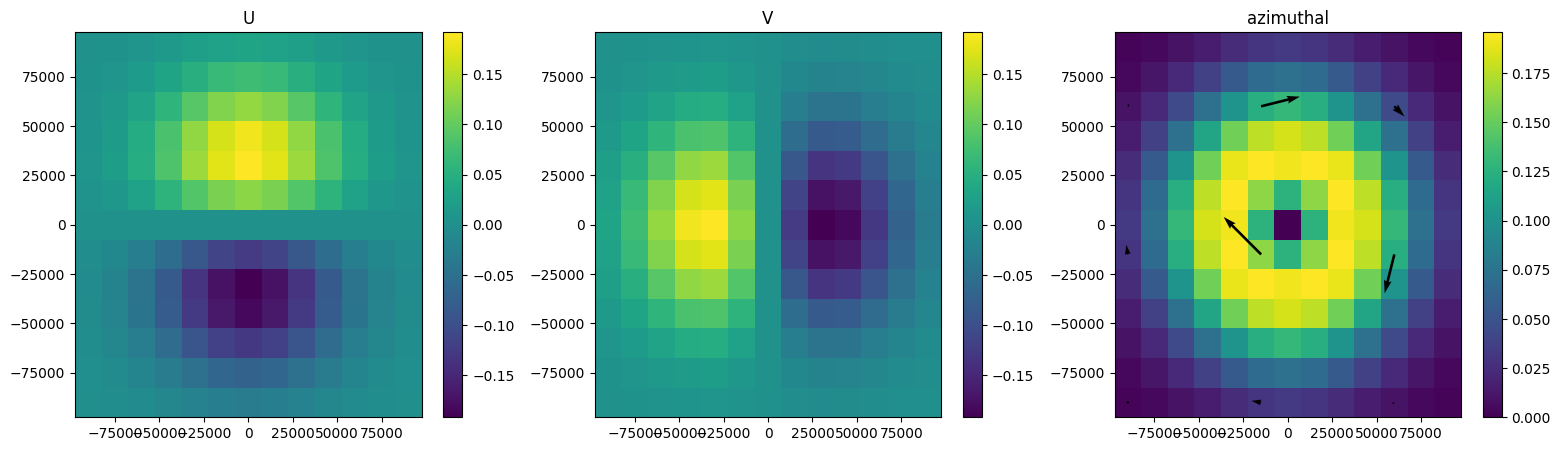

In [7]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))
ax1.set_title("U")
im = ax1.pcolormesh(X, Y, u_geos_t, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("V")
im = ax2.pcolormesh(X, Y, v_geos_t, shading="auto")
plt.colorbar(im, ax=ax2)
ax3.set_title("azimuthal")
im = ax3.pcolormesh(X, Y, azim_geos, shading="auto")
plt.colorbar(im, ax=ax3)
ax3.quiver(X[::5, ::5], Y[::5, ::5], u_geos_t[::5, ::5], v_geos_t[::5, ::5], color='k')
plt.show()

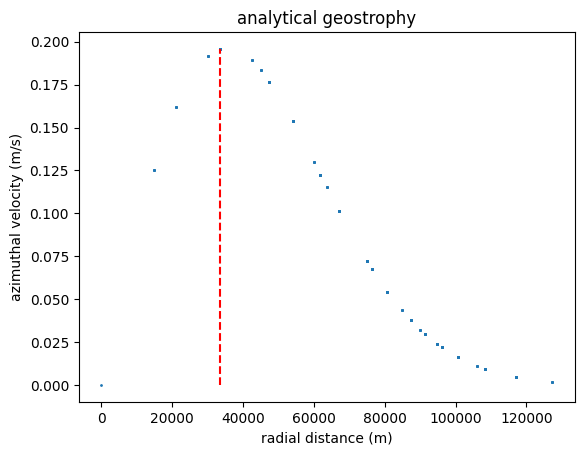

In [8]:
ax = plt.subplot()
ax.set_title("analytical geostrophy")
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azimuthal velocity (m/s)")
ax.scatter(R.flatten(), azim_geos.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_geos).flatten().argmax()], 
          ymin=azim_geos.min(), ymax=azim_geos.max(), colors="r", linestyles="dashed")
plt.show()

### Numerical

$f\mathbf{k} \times \mathbf{u_g} = -g \nabla \eta$

In [9]:
u_geos_est, v_geos_est = _geostrophy(ssh, stencil_weights, coriolis_factor)

u_geos_est_t = interpolation(u_geos_est, axis=1, pad_left=True)
v_geos_est_t = interpolation(v_geos_est, axis=0, pad_left=True)

azim_geos_est = magnitude(u_geos_est_t, v_geos_est_t, interpolate=False)

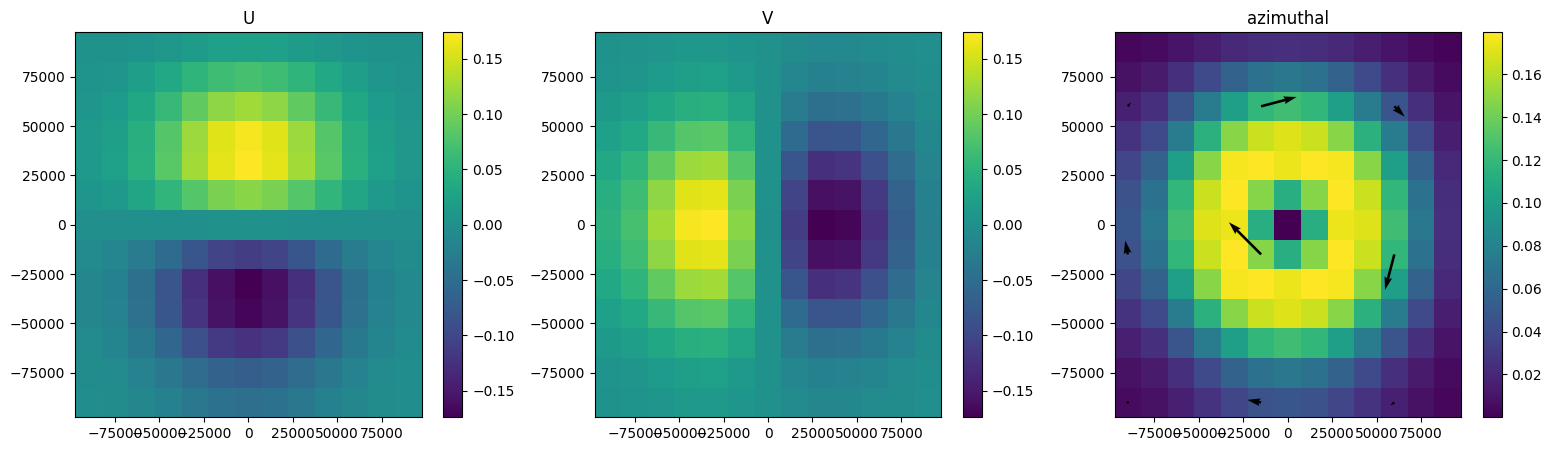

In [10]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))
ax1.set_title("U")
im = ax1.pcolormesh(X, Y, u_geos_est_t, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("V")
im = ax2.pcolormesh(X, Y, v_geos_est_t, shading="auto")
plt.colorbar(im, ax=ax2)
ax3.set_title("azimuthal")
im = ax3.pcolormesh(X, Y, azim_geos_est, shading="auto")
plt.colorbar(im, ax=ax3)
ax3.quiver(X[::5, ::5], Y[::5, ::5], u_geos_est_t[::5, ::5], v_geos_est_t[::5, ::5], color='k')
plt.show()

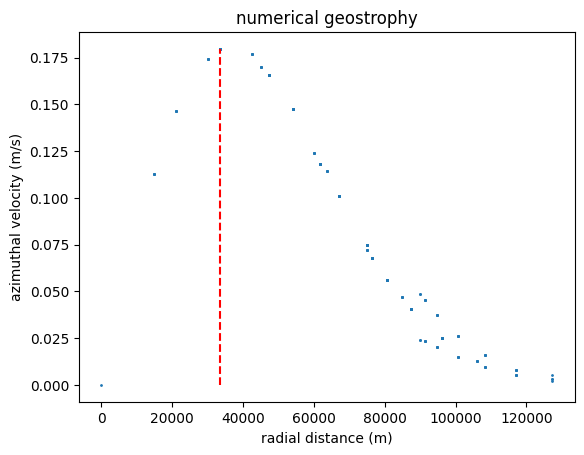

In [11]:
ax = plt.subplot()
ax.set_title("numerical geostrophy")
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azimuthal velocity (m/s)")
ax.scatter(R.flatten(), azim_geos_est.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_geos_est).flatten().argmax()], 
          ymin=azim_geos_est.min(), ymax=azim_geos_est.max(), colors="r", linestyles="dashed")
plt.show()

In [13]:
ge.compute_rmse(u_geos_t, u_geos_est_t), ge.compute_rmse(v_geos_t, v_geos_est_t)

(Array(0.00587266, dtype=float32), Array(0.00587266, dtype=float32))

## Cyclogeostrophic azimuthal velocity

### Analytical

$$V_{gr}=\frac{2V_g}{1+\sqrt{1+4V_g/(fr)}}$$

$$u_{gr} = u_g + sin(\theta) \frac{V_{gr}^2}{fr}$$
$$v_{gr} = v_g - cos(\theta) \frac{V_{gr}^2}{fr}$$

In [14]:
azim_cyclo = magnitude(u_cyclo_t, v_cyclo_t, interpolate=False)

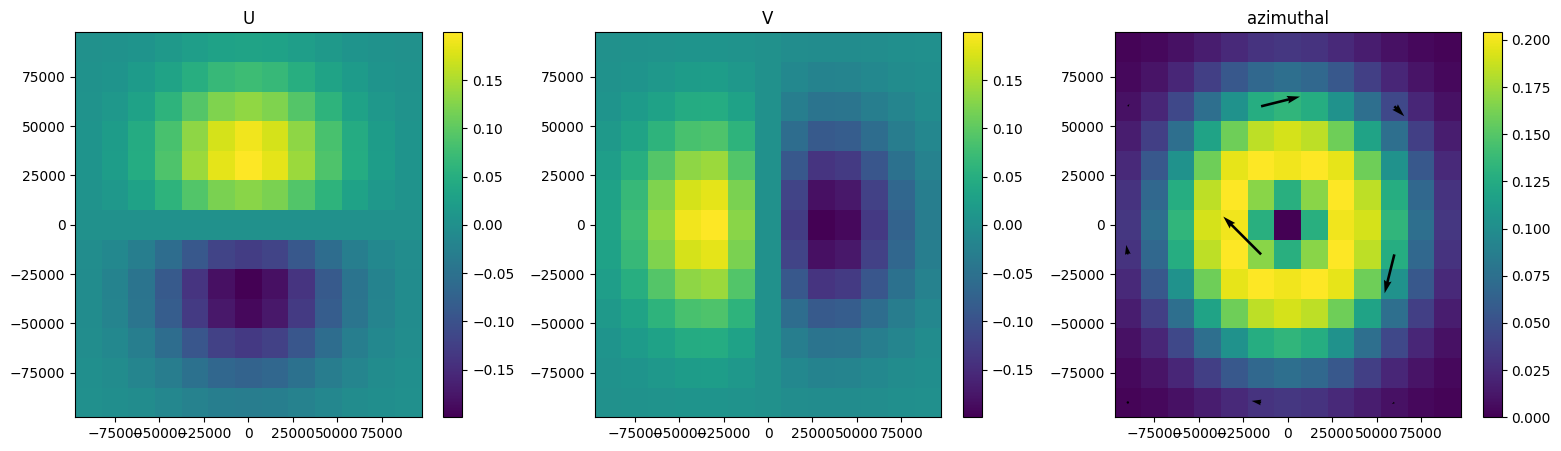

In [15]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))
ax1.set_title("U")
im = ax1.pcolormesh(X, Y, u_cyclo_t, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("V")
im = ax2.pcolormesh(X, Y, v_cyclo_t, shading="auto")
plt.colorbar(im, ax=ax2)
ax3.set_title("azimuthal")
im = ax3.pcolormesh(X, Y, azim_cyclo, shading="auto")
plt.colorbar(im, ax=ax3)
ax3.quiver(X[::5, ::5], Y[::5, ::5], u_cyclo_t[::5, ::5], v_cyclo_t[::5, ::5], color='k')
plt.show()

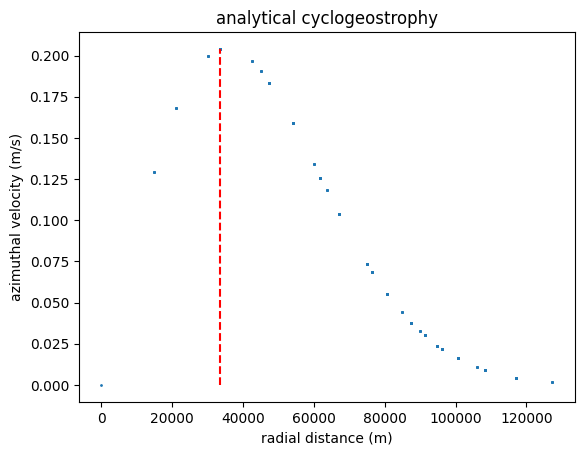

In [16]:
ax = plt.subplot()
ax.set_title("analytical cyclogeostrophy")
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azimuthal velocity (m/s)")
ax.scatter(R.flatten(), azim_cyclo.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_cyclo).flatten().argmax()], 
          ymin=azim_cyclo.min(), ymax=azim_cyclo.max(), colors="r", linestyles="dashed")
plt.show()

### Numerical

$\mathbf{u} - \frac{\mathbf{k}}{f} \times (\mathbf{u} \cdot \nabla \mathbf{u}) = \mathbf{u_g}$

In [17]:
u_geos_u = interpolation(u_geos_est_t, axis=1, pad_left=False)
v_geos_v = interpolation(v_geos_est_t, axis=0, pad_left=False)
mask = init_mask(u_geos_est_t)

#### Variational estimation

In [32]:
optim = optax.sgd(learning_rate=LR_VAR)
u_cyclo_est, v_cyclo_est, losses = _variational(u_geos_u, v_geos_v, stencil_weights, stencil_weights,
                                           coriolis_factor, coriolis_factor, mask,
                                           n_it=1000, optim=optim,
                                           return_losses=True)

u_cyclo_est_t = interpolation(u_cyclo_est, axis=1, pad_left=True)
v_cyclo_est_t = interpolation(v_cyclo_est, axis=0, pad_left=True)

azim_cyclo_est = magnitude(u_cyclo_est_t, v_cyclo_est_t, interpolate=False)

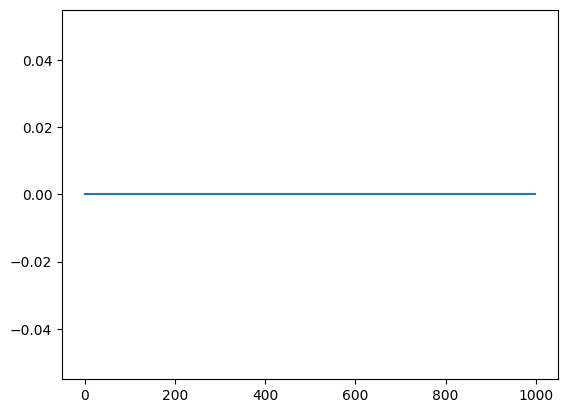

In [34]:
plt.plot(losses)

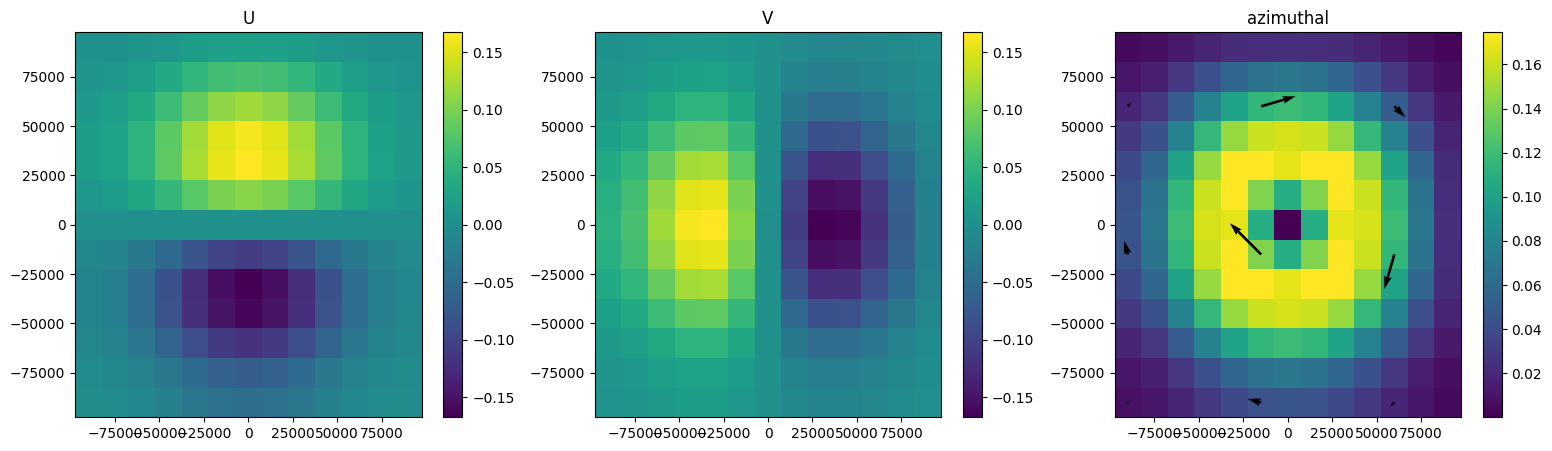

In [31]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))
ax1.set_title("U")
im = ax1.pcolormesh(X, Y, u_cyclo_est_t, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("V")
im = ax2.pcolormesh(X, Y, v_cyclo_est_t, shading="auto")
plt.colorbar(im, ax=ax2)
ax3.set_title("azimuthal")
im = ax3.pcolormesh(X, Y, azim_cyclo_est, shading="auto")
plt.colorbar(im, ax=ax3)
ax3.quiver(X[::5, ::5], Y[::5, ::5], u_cyclo_est_t[::5, ::5], v_cyclo_est_t[::5, ::5], color='k')
plt.show()

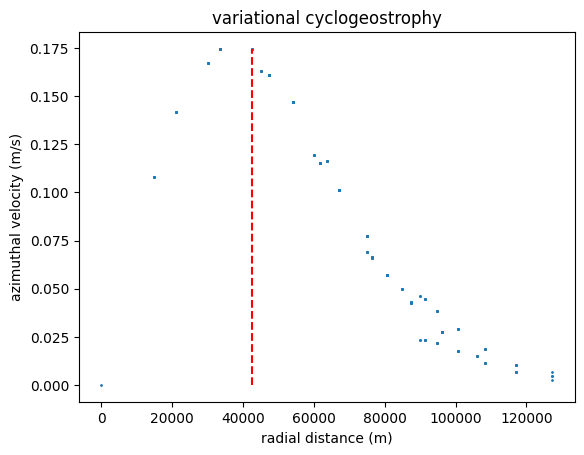

In [20]:
ax = plt.subplot()
ax.set_title("variational cyclogeostrophy")
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azimuthal velocity (m/s)")
ax.scatter(R.flatten(), azim_cyclo_est.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_cyclo_est).flatten().argmax()], 
          ymin=azim_cyclo_est.min(), ymax=azim_cyclo_est.max(), colors="r", linestyles="dashed")
plt.show()

In [21]:
ge.compute_rmse(u_cyclo_t, u_cyclo_est_t), ge.compute_rmse(v_cyclo_t, v_cyclo_est_t)

(Array(0.01003948, dtype=float32), Array(0.01003948, dtype=float32))

### Iterative estimation

$\mathbf{u}^{(n+1)} = \mathbf{u_g} + \frac{\mathbf{k}}{f} \times (\mathbf{u}^{(n)} \cdot \nabla \mathbf{u}^{(n)})$

#### Ioannou

Use of a convolution filter when computing the residuals.

In [22]:
u_cyclo_est, v_cyclo_est, _ = _iterative(u_geos_u, v_geos_v, stencil_weights, stencil_weights,
                                         coriolis_factor, coriolis_factor, mask,
                                         n_it=20, res_eps=0.01,
                                         use_res_filter=True, res_filter_size=3, 
                                         return_losses=False)

u_cyclo_est_t = interpolation(u_cyclo_est, axis=1, pad_left=True)
v_cyclo_est_t = interpolation(v_cyclo_est, axis=0, pad_left=True)

azim_cyclo_est = magnitude(u_cyclo_est_t, v_cyclo_est_t, interpolate=False)

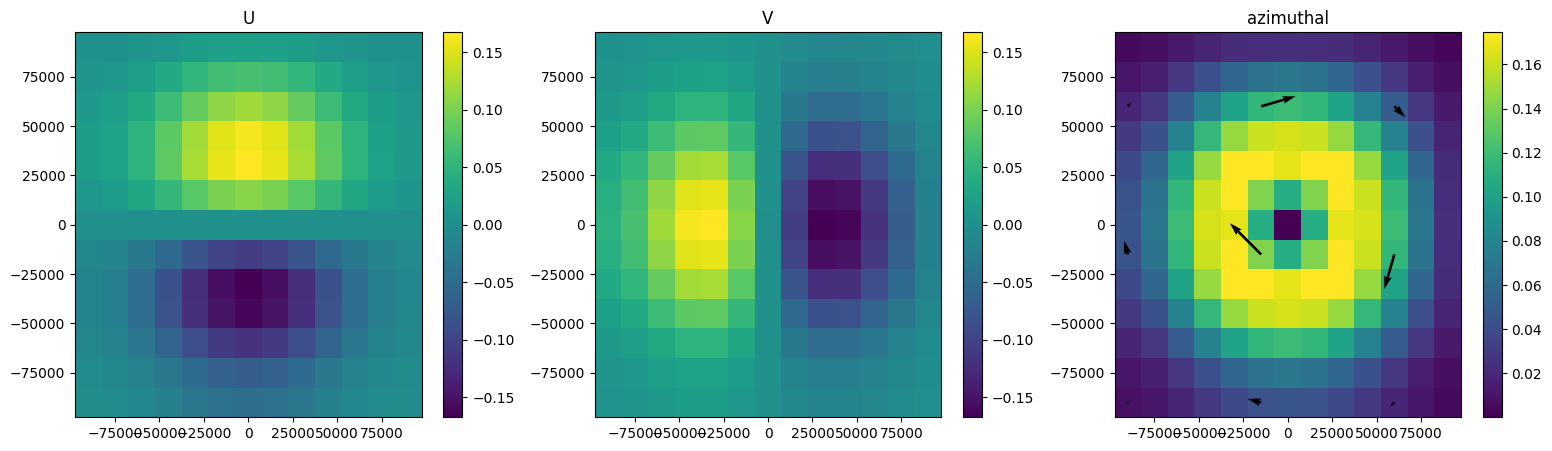

In [23]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))
ax1.set_title("U")
im = ax1.pcolormesh(X, Y, u_cyclo_est_t, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("V")
im = ax2.pcolormesh(X, Y, v_cyclo_est_t, shading="auto")
plt.colorbar(im, ax=ax2)
ax3.set_title("azimuthal")
im = ax3.pcolormesh(X, Y, azim_cyclo_est, shading="auto")
plt.colorbar(im, ax=ax3)
ax3.quiver(X[::5, ::5], Y[::5, ::5], u_cyclo_est_t[::5, ::5], v_cyclo_est_t[::5, ::5], color='k')
plt.show()

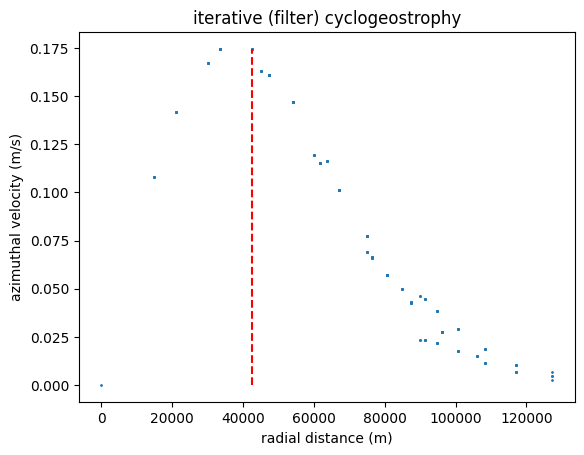

In [24]:
ax = plt.subplot()
ax.set_title("iterative (filter) cyclogeostrophy")
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azimuthal velocity (m/s)")
ax.scatter(R.flatten(), azim_cyclo_est.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_cyclo_est).flatten().argmax()], 
          ymin=azim_cyclo_est.min(), ymax=azim_cyclo_est.max(), colors="r", linestyles="dashed")
plt.show()

In [25]:
ge.compute_rmse(u_cyclo_t, u_cyclo_est_t), ge.compute_rmse(v_cyclo_t, v_cyclo_est_t)

(Array(0.01003948, dtype=float32), Array(0.01003948, dtype=float32))

#### Penven

No convolution filter, original approach.

In [26]:
u_cyclo_est, v_cyclo_est, _ = _iterative(u_geos_u, v_geos_v, stencil_weights, stencil_weights,
                                         coriolis_factor, coriolis_factor, mask,
                                         n_it=20, res_eps=0.01, 
                                         use_res_filter=False, res_filter_size=1, 
                                         return_losses=False)

u_cyclo_est_t = interpolation(u_cyclo_est, axis=1, pad_left=True)
v_cyclo_est_t = interpolation(v_cyclo_est, axis=0, pad_left=True)

azim_cyclo_est = magnitude(u_cyclo_est_t, v_cyclo_est_t, interpolate=False)

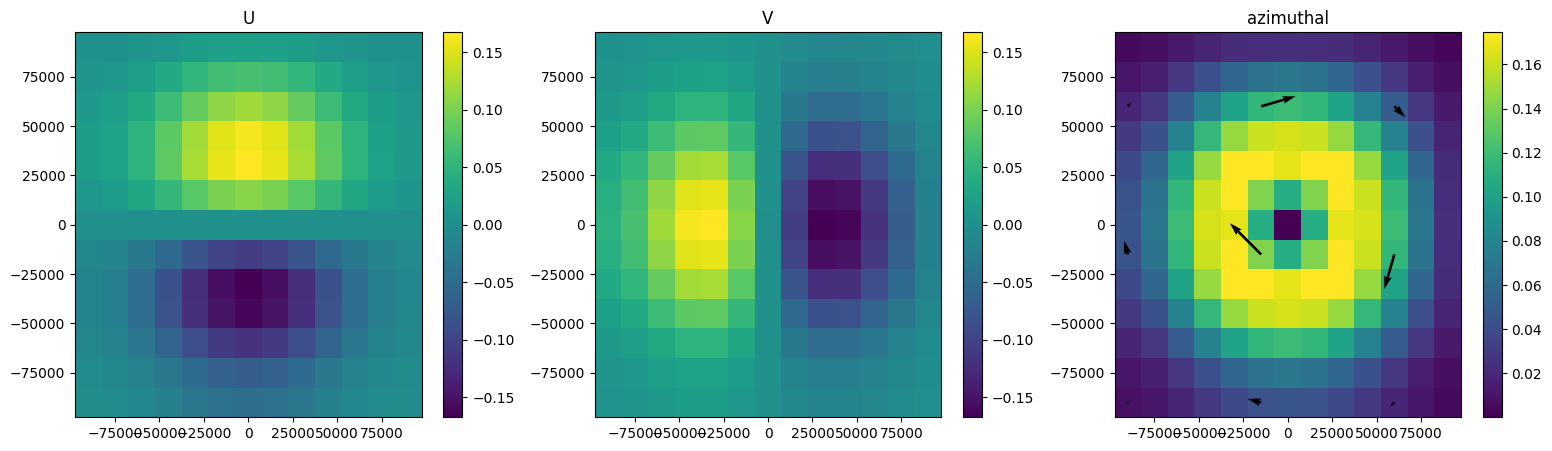

In [27]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(19, 5))
ax1.set_title("U")
im = ax1.pcolormesh(X, Y, u_cyclo_est_t, shading="auto")
plt.colorbar(im, ax=ax1)
ax2.set_title("V")
im = ax2.pcolormesh(X, Y, v_cyclo_est_t, shading="auto")
plt.colorbar(im, ax=ax2)
ax3.set_title("azimuthal")
im = ax3.pcolormesh(X, Y, azim_cyclo_est, shading="auto")
plt.colorbar(im, ax=ax3)
ax3.quiver(X[::5, ::5], Y[::5, ::5], u_cyclo_est_t[::5, ::5], v_cyclo_est_t[::5, ::5], color='k')
plt.show()

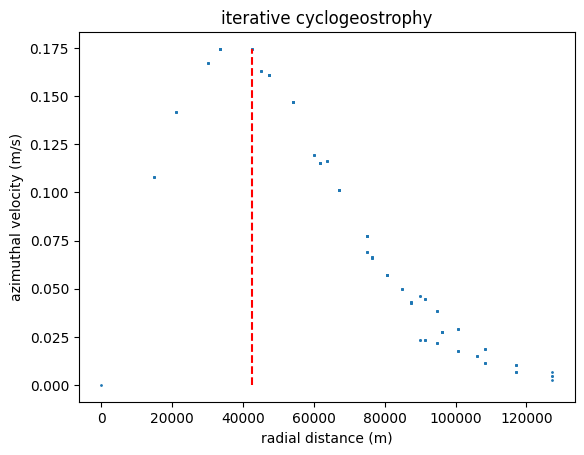

In [28]:
ax = plt.subplot()
ax.set_title("iterative cyclogeostrophy")
ax.set_xlabel("radial distance (m)")
ax.set_ylabel("azimuthal velocity (m/s)")
ax.scatter(R.flatten(), azim_cyclo_est.flatten(), s=1)
ax.vlines(R.flatten()[np.abs(azim_cyclo_est).flatten().argmax()], 
          ymin=azim_cyclo_est.min(), ymax=azim_cyclo_est.max(), colors="r", linestyles="dashed")
plt.show()

In [29]:
ge.compute_rmse(u_cyclo_t, u_cyclo_est_t), ge.compute_rmse(v_cyclo_t, v_cyclo_est_t)

(Array(0.01003948, dtype=float32), Array(0.01003948, dtype=float32))